# Exercise Chapter 8 
Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

In [1]:
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

In [2]:
import mistat
import networkx as nx
from pgmpy.estimators import HillClimbSearch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

/usr/local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Exercise 1

In [3]:
from skfda import FDataGrid
from skfda.representation.interpolation import SplineInterpolation

dissolution = mistat.load_data('DISSOLUTION.csv')

# convert the data to FDataGrid
data = []
labels = []
names = []
for label, group in dissolution.groupby('Label'):
  data.append(group['Data'].values)
  labels.append('Reference' if label.endswith('R') else 'Test')
  names.append(label)
labels = np.array(labels)
grid_points = np.array(sorted(dissolution['Time'].unique()))
fd = FDataGrid(np.array(data), grid_points,
       dataset_name='Dissolution',
       argument_names=['Time'],
       coordinate_names=['Dissolution'])

In [4]:
from skfda.preprocessing.registration import ShiftRegistration
shift_registration = ShiftRegistration()

fd_registered = {}
for order in (1, 2, 3):
    fd.interpolation = SplineInterpolation(interpolation_order=order)
    fd_registered[order] = shift_registration.fit_transform(fd)

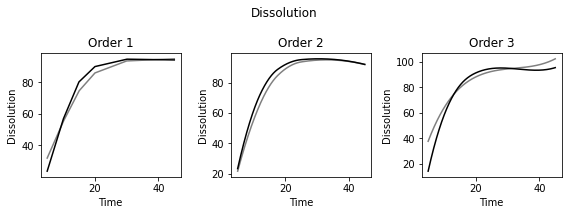

In [5]:
from skfda.exploratory import stats

group_colors = {'Reference': 'grey', 'Test': 'black'}

fig, axes = plt.subplots(ncols=3, figsize=(8, 3))
for ax, order in zip(axes, (1, 2, 3)):
    mean_ref = stats.mean(fd_registered[order][labels=='Reference'])
    mean_test = stats.mean(fd_registered[order][labels=='Test'])
    means = mean_ref.concatenate(mean_test)
    means.plot(axes=[ax], group=['Reference', 'Test'], group_colors=group_colors)
    ax.set_title(f'Order {order}')
plt.tight_layout()

# Exercise 2

In [6]:
import skfda
from skfda import FDataGrid

pinchraw = skfda.datasets.fetch_cran('pinchraw', 'fda')['pinchraw']
pinchtime = skfda.datasets.fetch_cran('pinch', 'fda')['pinchtime']

fd = FDataGrid(pinchraw.transpose(), pinchtime)

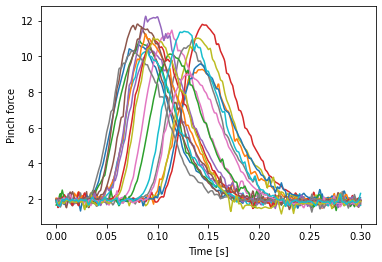

In [7]:
fig = fd.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

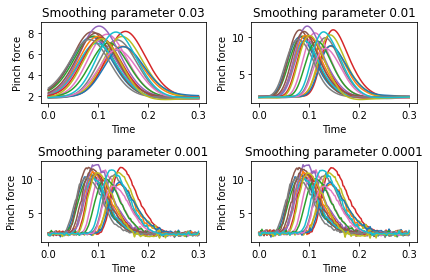

In [8]:
import itertools
from skfda.preprocessing.smoothing.kernel_smoothers import NadarayaWatsonSmoother

def plotSmoothData(fd, smoothing_parameter, ax):
    smoother = NadarayaWatsonSmoother(smoothing_parameter=smoothing_parameter)
    fd_smooth = smoother.fit_transform(fd)
    _ = fd_smooth.plot(axes=[ax])
    ax.set_title(f'Smoothing parameter {smoothing_parameter}')
    ax.set_xlabel('Time')
    ax.set_ylabel('Pinch force')

fig, axes = plt.subplots(ncols=2, nrows=2)
axes = list(itertools.chain(*axes))  # flatten list of lists
for i, sp in enumerate([0.03, 0.01, 0.001, 0.0001]):
    plotSmoothData(fd, sp, axes[i])
plt.tight_layout()

In [9]:
smoother = NadarayaWatsonSmoother(smoothing_parameter=0.005)
fd_smooth = smoother.fit_transform(fd)

In [10]:
max_idx = fd_smooth.data_matrix.argmax(axis=1)
landmarks = [pinchtime[idx] for idx in max_idx]

In [11]:
from skfda.preprocessing.registration import landmark_shift
fd_landmark = landmark_shift(fd_smooth, landmarks)

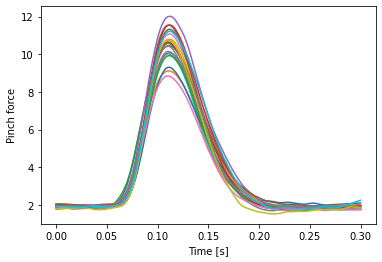

In [12]:
fig = fd_landmark.plot()
ax = fig.axes[0]
ax.set_xlabel('Time [s]')
ax.set_ylabel('Pinch force')
plt.show()

# Exercise 3

In [13]:
import warnings
warnings.filterwarnings('ignore', category=UserWarning)

In [14]:
import skfda

moisturespectrum = skfda.datasets.fetch_cran('Moisturespectrum', 'fds')
moisturevalues = skfda.datasets.fetch_cran('Moisturevalues', 'fds')

frequencies = moisturespectrum['Moisturespectrum']['x']
spectra = moisturespectrum['Moisturespectrum']['y']
moisture = moisturevalues['Moisturevalues']

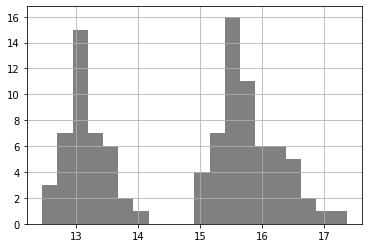

In [15]:
_ = pd.Series(moisture).hist(bins=20, color='grey', label='Moisture content')

In [16]:
moisture_class = ['high' if m > 14.5 else 'low' for m in moisture]

In [17]:
intensities = spectra.transpose()
fd = skfda.FDataGrid(intensities, frequencies)

# divide each sample spectrum by it's mean intensities
intensities_normalized = (intensities - intensities.mean(dim='dim_0')) / intensities.std(dim='dim_0')
fd_normalized = skfda.FDataGrid(intensities_normalized, frequencies)

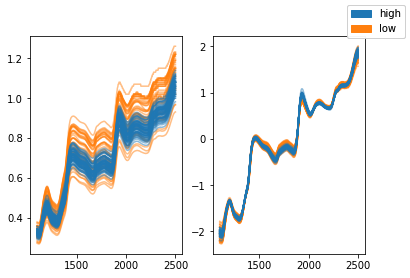

In [18]:
fig, axes = plt.subplots(ncols=2)
_ = fd.plot(axes=axes[0], alpha=0.5,
            # color lines by moisture class
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})
_ = fd_normalized.plot(axes=axes[1], alpha=0.5,
            group=moisture_class, group_names={'high': 'high', 'low': 'low'})

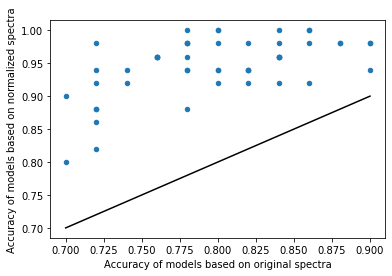

original      0.7976
normalized    0.9468
dtype: float64

In [19]:
from skfda.ml.classification import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

accuracies = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture_class, random_state=rs, test_size=0.5)
    knn_original = KNeighborsClassifier()
    knn_original.fit(X_train, y_train)
    acc_original = accuracy_score(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture_class, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsClassifier()
    knn_normalized.fit(X_train, y_train)
    acc_normalized = accuracy_score(y_test, knn_normalized.predict(X_test))
    accuracies.append({
        'original': acc_original,
        'normalized': acc_normalized,
    })
accuracies = pd.DataFrame(accuracies)
ax  = accuracies.plot.scatter(x='original', y='normalized')
_ = ax.plot([0.7, 0.9], [0.7, 0.9], color='black')
ax.set_xlabel('Accuracy of models based on original spectra')
ax.set_ylabel('Accuracy of models based on normalized spectra')
plt.show()

# mean of accuracies
mean_accuracy = accuracies.mean()
mean_accuracy

# Exercise 4

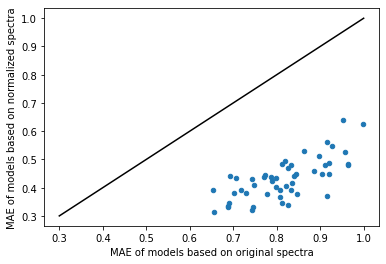

original      0.817016
normalized    0.433026
dtype: float64

In [20]:
from skfda.ml.regression import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

mae = []
for rs in range(50):
    X_train, X_test, y_train, y_test = train_test_split(fd,
        moisture, random_state=rs, test_size=0.5)
    knn_original = KNeighborsRegressor()
    knn_original.fit(X_train, y_train)
    mae_original = mean_absolute_error(y_test, knn_original.predict(X_test))

    X_train, X_test, y_train, y_test = train_test_split(fd_normalized,
        moisture, random_state=rs, test_size=0.5)
    knn_normalized = KNeighborsRegressor()
    knn_normalized.fit(X_train, y_train)
    mae_normalized = mean_absolute_error(y_test, knn_normalized.predict(X_test))
    mae.append({
        'original': mae_original,
        'normalized': mae_normalized,
    })
mae = pd.DataFrame(mae)
ax  = mae.plot.scatter(x='original', y='normalized')
ax.plot([0.3, 1.0], [0.3, 1.0], color='black')
ax.set_xlabel('MAE of models based on original spectra')
ax.set_ylabel('MAE of models based on normalized spectra')
plt.show()

# mean of MAE
mean_mae = mae.mean()
mean_mae

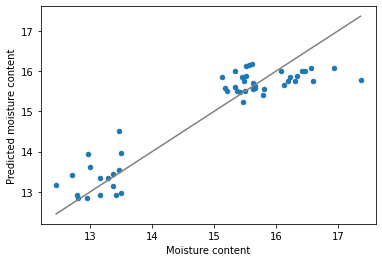

In [21]:
y_pred = knn_normalized.predict(X_test)
predictions = pd.DataFrame({'actual': y_test, 'predicted': y_pred})
minmax = [min(*y_test, *y_pred), max(*y_test, *y_pred)]

ax = predictions.plot.scatter(x='actual', y='predicted')
ax.set_xlabel('Moisture content')
ax.set_ylabel('Predicted moisture content')
ax.plot(minmax, minmax, color='grey')
plt.show()

# Exercise 5

In [22]:
from skfda.preprocessing.dim_reduction.projection import FPCA

fpca_original = FPCA(n_components=2)
_ = fpca_original.fit(fd)

fpca_normalized = FPCA(n_components=2)
_ = fpca_normalized.fit(fd_normalized)

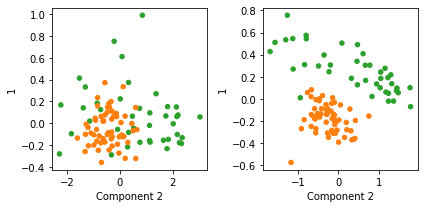

In [23]:
def plotFPCA(fpca, fd, ax):
  fpca_df = pd.DataFrame(fpca.transform(fd))
  fpca_df.plot.scatter(x=0, y=1,
      c=['C1' if mc == 'high' else 'C2' for mc in moisture_class], ax=ax)
  ax.set_xlabel('Component 1')
  ax.set_xlabel('Component 2')

fig, axes = plt.subplots(ncols=2, figsize=[6, 3])
plotFPCA(fpca_original, fd, axes[0])
plotFPCA(fpca_normalized, fd_normalized, axes[1])
plt.tight_layout()

# Exercise 6

In [24]:
from mistat.nlp import globalWarmingBlogs
blogs = globalWarmingBlogs()

In [25]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph: # ignore empty paragraphs
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

In [26]:
import re
from sklearn.feature_extraction.text import CountVectorizer

def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    text = '\n'.join(line for line in text.split('\n')
                     if not line.startswith('ntsb'))
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (123, 1025)
total number of terms 2946


In [27]:
termCounts = np.array(counts.sum(axis=0)).flatten()
topCounts = termCounts.argsort()
terms = vectorizer.get_feature_names_out()
for n in reversed(topCounts[-10:]):
  print(f'{terms[n]} & {termCounts[n]} \\\\')

global & 63 \\
climate & 59 \\
warming & 57 \\
change & 55 \\
ice & 35 \\
sea & 34 \\
earth & 33 \\
ocean & 29 \\
temperatures & 28 \\
heat & 25 \\


In [28]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [29]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(5)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [30]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [31]:
print("{\\tiny")
"}"

{\tiny


'}'

In [32]:
svd = TruncatedSVD(10)
norm_tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(norm_tfidf)

In [33]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [34]:
print("{\\tiny")
print(df.iloc[:, :10].style.format(precision=2).hide(axis='index').to_latex(hrules=True))
"}"

{\tiny


\begin{tabular}{lrlrlrlrlr}
\toprule
Topic 1 & Loading 1 & Topic 2 & Loading 2 & Topic 3 & Loading 3 & Topic 4 & Loading 4 & Topic 5 & Loading 5 \\
\midrule
change & 0.24 & ice & 0.39 & sea & 0.25 & extreme & 0.54 & snow & 0.39 \\
climate & 0.24 & sea & 0.35 & earth & 0.23 & events & 0.31 & cover & 0.23 \\
global & 0.23 & sheets & 0.27 & energy & 0.21 & heat & 0.23 & sea & 0.17 \\
sea & 0.22 & shrinking & 0.19 & light & 0.21 & precipitation & 0.20 & level & 0.12 \\
warming & 0.21 & level & 0.17 & gases & 0.19 & light & 0.13 & climate & 0.12 \\
ice & 0.20 & arctic & 0.15 & ice & 0.18 & earth & 0.13 & temperatures & 0.12 \\
temperature & 0.18 & ocean & 0.13 & infrared & 0.17 & energy & 0.12 & hurricanes & 0.12 \\
ocean & 0.16 & declining & 0.10 & greenhouse & 0.16 & gases & 0.12 & decreased & 0.11 \\
earth & 0.16 & levels & 0.08 & level & 0.15 & greenhouse & 0.11 & temperature & 0.10 \\
extreme & 0.15 & glaciers & 0.07 & atmosphere & 0.12 & infrared & 0.11 & increase & 0.10 \\
\bottomrul

'}'

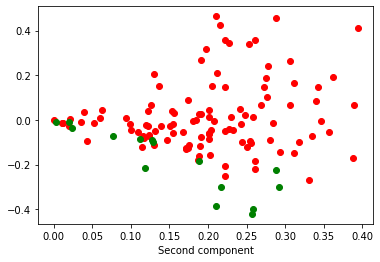

In [35]:
fig, ax = plt.subplots()
blog1 = [label == 'blog-1' for label in labels]
blog2 = [label == 'blog-2' for label in labels]
ax.plot(lsa_tfidf[blog1, 0], lsa_tfidf[blog1, 1], 'ro')
ax.plot(lsa_tfidf[blog2, 0], lsa_tfidf[blog2, 1], 'go')
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 7

In [36]:
from mistat.nlp import covid19Blogs
blogs = covid19Blogs()

In [37]:
paragraphs = []
labels = []
for blog, text in blogs.items():
  for paragraph in text.split('\n'):
    paragraph = paragraph.strip()
    if not paragraph:
      continue
    paragraphs.append(paragraph)
    labels.append(blog)

def preprocessor(text):
  text = text.lower()
  text = re.sub(r'\d[\d,]*', '', text)
  text = '\n'.join(line for line in text.split('\n')
                   if not line.startswith('ntsb'))
  return text

vectorizer = CountVectorizer(preprocessor=preprocessor, stop_words='english')
counts = vectorizer.fit_transform(paragraphs)

In [38]:
tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [39]:
svd = TruncatedSVD(10)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)

In [40]:
terms = vectorizer.get_feature_names_out()
data = {}
for i, component in enumerate(svd.components_, 1):
  compSort = component.argsort()
  idx = list(reversed(compSort[-10:]))
  data[f'Topic {i}'] = [terms[n] for n in idx]
  data[f'Loading {i}'] = [component[n] for n in idx]
df = pd.DataFrame(data)

In [41]:
print("{\\tiny")
print(df.iloc[:, :10].style.format(precision=2).hide(axis='index').to_latex(hrules=True))
"}"

{\tiny
\begin{tabular}{lrlrlrlrlr}
\toprule
Topic 1 & Loading 1 & Topic 2 & Loading 2 & Topic 3 & Loading 3 & Topic 4 & Loading 4 & Topic 5 & Loading 5 \\
\midrule
labour & 0.29 & labour & 0.28 & economic & 0.24 & capacity & 0.22 & covid & 0.24 \\
covid & 0.22 & south & 0.27 & percent & 0.23 & financial & 0.19 & america & 0.20 \\
impact & 0.19 & north & 0.22 & covid & 0.19 & firms & 0.18 & reset & 0.20 \\
market & 0.19 & differences & 0.19 & gdp & 0.17 & household & 0.17 & economic & 0.18 \\
south & 0.18 & americas & 0.17 & impact & 0.15 & international & 0.17 & needs & 0.17 \\
america & 0.16 & channel & 0.17 & imf & 0.13 & state & 0.14 & latin & 0.16 \\
pandemic & 0.15 & agenda & 0.14 & social & 0.13 & access & 0.13 & social & 0.16 \\
channel & 0.15 & covid & 0.13 & pre & 0.12 & largely & 0.13 & asymmetric & 0.14 \\
economic & 0.14 & post & 0.11 & growth & 0.10 & depends & 0.13 & consequences & 0.13 \\
north & 0.14 & welfare & 0.09 & world & 0.10 & differences & 0.12 & labor & 0.11 \\

'}'

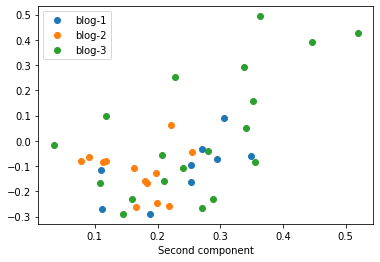

In [42]:
fig, ax = plt.subplots()
for blog in blogs:
    match = [label == blog for label in labels]
    ax.plot(lsa_tfidf[match, 0], lsa_tfidf[match, 1], 'o', label=blog)
ax.legend()
ax.set_xlabel('First component')
ax.set_xlabel('Second component')
plt.show()

# Exercise 8

In [43]:
data = mistat.load_data('LAPTOP_REVIEWS')
data['Review'] = data['Review title'] + ' ' + data['Review content']
reviews = data.dropna(subset=['User rating', 'Review title', 'Review content'])

In [44]:
import re
from sklearn.feature_extraction.text import CountVectorizer
def preprocessor(text):
    text = text.lower()
    text = re.sub(r'\d[\d,]*', '', text)
    return text

vectorizer = CountVectorizer(preprocessor=preprocessor,
                             stop_words='english')
counts = vectorizer.fit_transform(reviews['Review'])
print('shape of DTM', counts.shape)
print('total number of terms', np.sum(counts))

shape of DTM (7433, 12823)
total number of terms 251566


In [45]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidfTransformer = TfidfTransformer(smooth_idf=False, norm=None)
tfidf = tfidfTransformer.fit_transform(counts)

In [46]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
svd = TruncatedSVD(20)
tfidf = Normalizer().fit_transform(tfidf)
lsa_tfidf = svd.fit_transform(tfidf)
print(lsa_tfidf.shape)

(7433, 20)


In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

outcome = ['positive' if rating == 5 else 'negative'
           for rating in reviews['User rating']]

# split dataset into 60% training and 40% test set
Xtrain, Xtest, ytrain, ytest = train_test_split(lsa_tfidf, outcome,
                                                test_size=0.4, random_state=1)

# run logistic regression model on training
logit_reg = LogisticRegression(solver='lbfgs')
logit_reg.fit(Xtrain, ytrain)

# print confusion matrix and accuracty
accuracy = accuracy_score(ytest, logit_reg.predict(Xtest))
print(accuracy)
confusion_matrix(ytest, logit_reg.predict(Xtest))

0.7683254875588433


array([[ 855,  391],
       [ 298, 1430]])